In [47]:

import pandas as pd
import numpy as np
import cv2
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

### Directorio de Data

In [48]:
path = "../input/face-mask-12k-images-dataset/Face Mask Dataset/"

In [50]:
dataset = {
    "image_path": [],
    "mask_status": [],
    "where": []
}

for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.png"):
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)
            
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
1,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
2,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
3,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
4,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation


### Visualisations

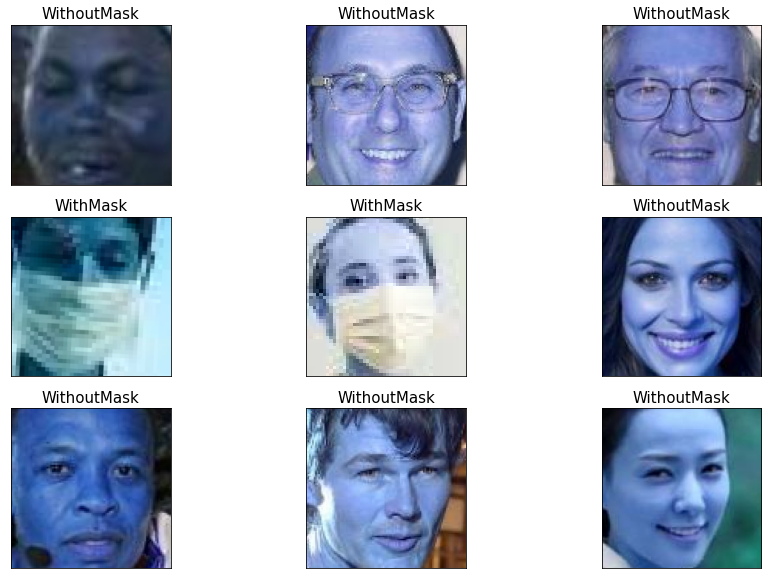

In [52]:
plt.figure(figsize = (15, 10))

for i in range(9):
    random = np.random.randint(1, len(dataset))
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random,"mask_status"], size = 15)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [56]:

train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

print(train_df.head(10))

## Mezclar data
train_df = train_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)
valid_df = valid_df.sample(frac = 1)

print("\n Despues de mezclar \n")
print(train_df.head(10))

                                             image_path  mask_status  where
1792  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1793  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1794  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1795  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1796  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1797  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1798  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1799  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1800  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1801  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train

 Despues de mezclar 

                                              image_path  mask_status  where
11762  ../input/face-mask-12k-images-dataset/Face Mas...     Wit

### Visualising the distribution of train test and validation set

In [57]:
train_df = train_df.reset_index().drop("index", axis = 1)
train_df.head()

,image_path,mask_status,where
0,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train
1,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train
2,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train
3,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Train
4,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train


In [58]:
## Leer las imagenes en una lista y cambiar el size a(150,150)
data = []
image_size = 150

for i in range(len(train_df)):
    ## en grayscale
    img_array = cv2.imread(train_df["image_path"][i], cv2.IMREAD_GRAYSCALE)

    ## Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    ##Encoding the image with the label
    if train_df["mask_status"][i] == "WithMask":
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [59]:
data = np.array(data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [60]:
## medidas de imagen
data[0][0].shape

(150, 150)

In [61]:
## mezclar la data para asegurarse que no esta en orden
np.random.shuffle(data)

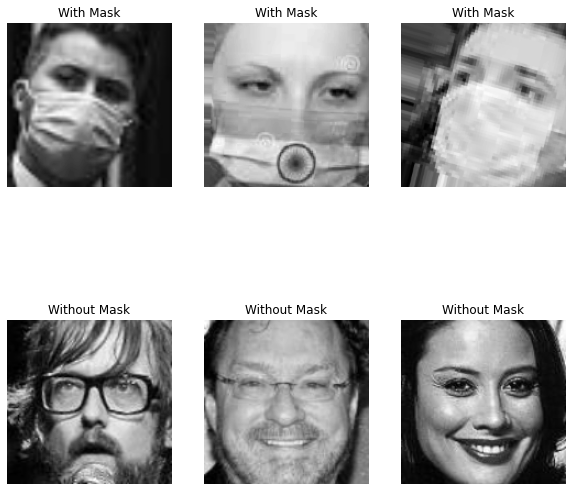

In [62]:
## ver los training samples

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for row in range(2):
    for col in range(3):
        image_index = row*100+col
        
        ax[row, col].axis("off")
        ax[row,col].imshow(data[image_index][0], cmap = "gray")
    
        if data[image_index][1] == 0:
            ax[row, col].set_title("Without Mask")
        else:
            ax[row, col].set_title("With Mask")
            
plt.show()

### Preracion de data antes de ser cargada al modelo

In [63]:
X = []
y = []

for image in data:
    X.append(image[0])
    y.append(image[1])
    
X = np.array(X)
y = np.array(y)

In [64]:
## normalizacion de la data
X = X/255

## Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Building the model

In [19]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))


In [67]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [68]:
# X_train = X_train.reshape(-1, 32, 150, 150)
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val.shape[2], 1)

history = model.fit(X_train, y_train, epochs=5, batch_size = 32)

Epoch 1/5
250/250 [==============================] - 514s 2s/step - loss: 0.0615 - accuracy: 0.9792
Epoch 2/5
250/250 [==============================] - 542s 2s/step - loss: 0.0673 - accuracy: 0.9763
Epoch 3/5
250/250 [==============================] - 496s 2s/step - loss: 0.0134 - accuracy: 0.9950
Epoch 4/5
250/250 [==============================] - 495s 2s/step - loss: 0.0119 - accuracy: 0.9969
Epoch 5/5
250/250 [==============================] - 496s 2s/step - loss: 0.0094 - accuracy: 0.9965


In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 147456)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               18874496  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 18,912,193
Trainable params: 18,912,193
Non-trainable params: 0
____________________________________________

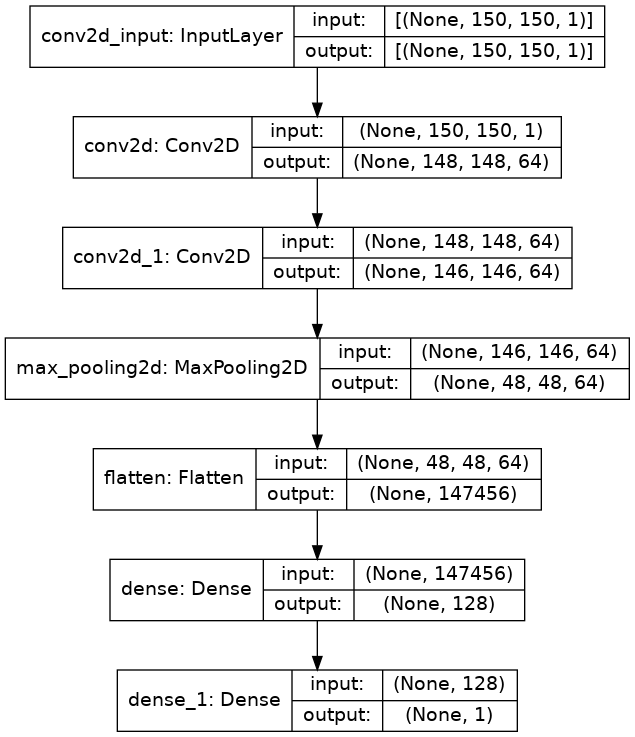

In [70]:
plot_model(model, to_file="model.png", show_shapes=True)

In [72]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 31s 491ms/step - loss: 0.0690 - accuracy: 0.9765


[0.06902725994586945, 0.9764999747276306]

In [73]:
def show_results(log):
  val_loss = log.history['loss']
  val_acc = log.history['accuracy']
      
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  ax1, ax2 = axes

  ax1.plot(val_loss, label='train')
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')

  ax2.plot(val_acc, label='train')
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
  for ax in axes: ax.legend()

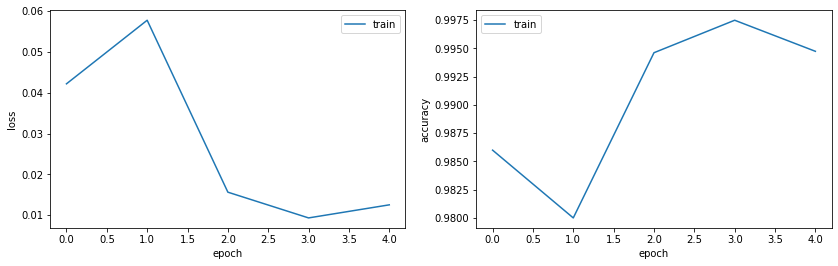

In [74]:
show_results(history)

array([[1.],
       [1.],
       [1.]], dtype=float32)

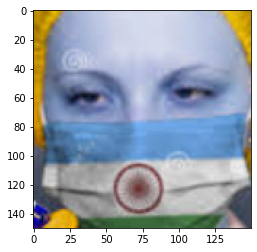

In [112]:
sample_mask_img = cv2.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1558.png')
sample_mask_img = cv2.resize(sample_mask_img,(150,150))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[-1,150,150,1])
sample_mask_img = sample_mask_img/255.0

model.predict(sample_mask_img)

array([[1.],
       [1.],
       [1.]], dtype=float32)

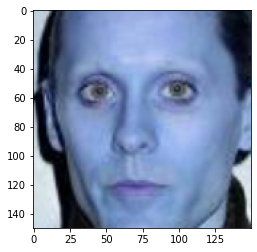

In [113]:
sample_mask_img = cv2.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask/1174.png')
sample_mask_img = cv2.resize(sample_mask_img,(150,150))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[-1,150,150,1])
sample_mask_img = sample_mask_img/255.0

model.predict(sample_mask_img)